In [646]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [647]:
def load_file(f):
    fixprice = lambda x: float(x.replace(',', '.'))
    df = pd.read_csv(f)
    if "Gmt time" in df.columns:
        df['Date'] = pd.to_datetime(df['Gmt time'], format="%d.%m.%Y %H:%M:%S.%f")
    elif "time" in df.columns:
        df['Date'] = pd.to_datetime(df['time'], unit="s")
        df['Date'] = df['Date'] + np.timedelta64(3 * 60, "m")
        df[['Date', 'Open', 'High', 'Low', 'Close']] = df[['Date', 'open', 'high', 'low', 'close']]
        df = df[['Date', 'Open', 'High', 'Low', 'Close']]
    elif "Tarih" in df.columns:
        df['Date'] = pd.to_datetime(df['Tarih'], format="%d.%m.%Y")
        df['Open'] = df['Açılış'].apply(fixprice)
        df['High'] = df['Yüksek'].apply(fixprice)
        df['Low'] = df['Düşük'].apply(fixprice)
        df['Close'] = df['Şimdi'].apply(fixprice)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [648]:
def plot_candles(df, ax, l=0):
    """
        Plots candles
        l: plot last n candles. If set zero, draw all
    """
    db = df.copy()
    if l > 0:
        db = db[-l:]
    db = db.reset_index(drop=True).reset_index()
    db["Up"] = db["Close"] > db["Open"]
    db["Bottom"] = np.where(db["Up"], db["Open"], db["Close"])
    db["Bar"] = db["High"] - db["Low"]
    db["Body"] = abs(db["Close"] - db["Open"])
    db["Color"] = np.where(db["Up"], "g", "r")
    ax.yaxis.tick_right()
    ax.bar(db["index"], bottom=db["Low"], height=db["Bar"], width=0.25, color="#000000")
    ax.bar(db["index"], bottom=db["Bottom"], height=db["Body"], width=0.5, color=db["Color"])
    t = 0.5
    ax.plot(db["Q0"], color="r", ls="-.", alpha=t)
    ax.plot(db["Q1"], color="g", alpha=t)
    ax.plot(db["Q2"], color="b", alpha=t)
    ax.plot(db["Q3"], color="g", alpha=t)
    ax.plot(db["Q4"], color="r", ls="-.", alpha=t)

In [649]:
def roundit(v, d):
    r = None
    try:
        r = round(v / d) * d
    except:
        pass
    return r

In [650]:
def add_data(df, sample_size, tick):
    #col = df["Close"].shift(1)
    col = df["Open"]
    df["OC"] = (df["Close"] - col) / col
    # we are shifting to not to have lookahead bias in the data
    df["Q0"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.0))).apply(roundit, args=[tick])
    df["Q1"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.25))).apply(roundit, args=[tick])
    df["Q2"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.5))).apply(roundit, args=[tick])
    df["Q3"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.75))).apply(roundit, args=[tick])
    df["Q4"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(1.0))).apply(roundit, args=[tick])
    return df.dropna().reset_index(drop=True)

In [651]:
def hist(df):
    plt.figure(figsize=(16, 9))
    plt.hist(df["OC"], bins=300, alpha=0.5)
    plt.axvline(df["OC"].quantile(0.0), ls="-.", color="r")
    plt.axvline(df["OC"].quantile(0.25), ls="-.", color="g")
    plt.axvline(df["OC"].quantile(0.75), ls="-.", color="g")
    plt.axvline(df["OC"].quantile(1.0), ls="-.", color="r")
    plt.axvline(df["OC"].quantile(0.5), ls="-.", color="#000000")
    plt.show()
    print("Median (Q2):", df["OC"].median())
    print("Q3 - Q4:", df["OC"].quantile(1.0) - df["OC"].quantile(0.75))
    print("Q0 - Q1:", df["OC"].quantile(0.25) - df["OC"].quantile(0.0))

In [652]:
def iqr_stats(df, c1="Q1", c2="Q3"):
    col1 = df[c1]
    col2 = df[c2]
    db = df[(df["Close"] >= col1) & (df["Close"] <= col2)]
    r = len(db) / len(df) * 100
    print("{}-{}: {:.2f}%".format(c1, c2, r))

In [653]:
sym = "TSLA"
period = "1d"
fl = "./{} {}.csv".format(period, sym)
df = load_file(fl)
tick = 0.01 # minimum tick (0.25 for E-mini SP futures, 0.00001 for FOREX, 0.001 for XXX/JPY, 0.01 for XAUUSD, 0.10 for Gold Futures)
sample_size = 1000
df = add_data(df, sample_size, tick)

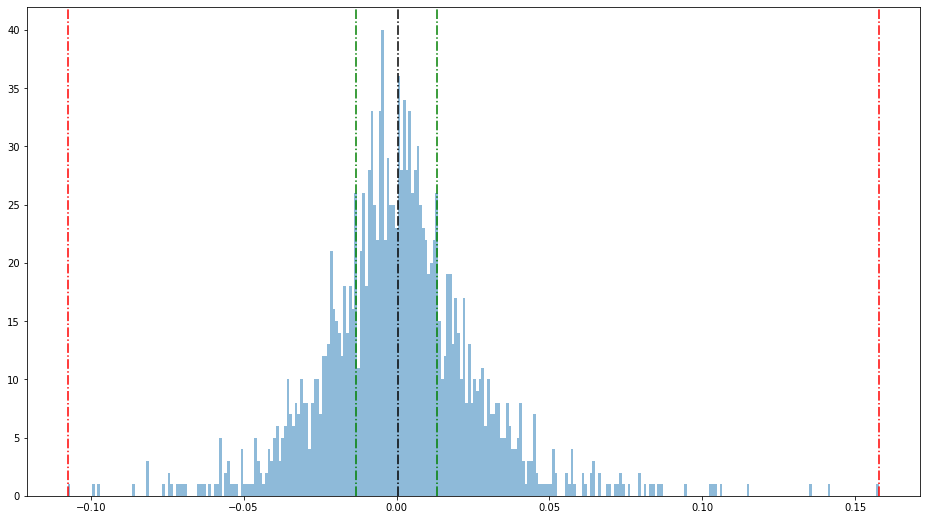

Median (Q2): 0.0003634114311573365
Q3 - Q4: 0.14448731927170932
Q0 - Q1: 0.09440655740813506


In [654]:
hist(df)

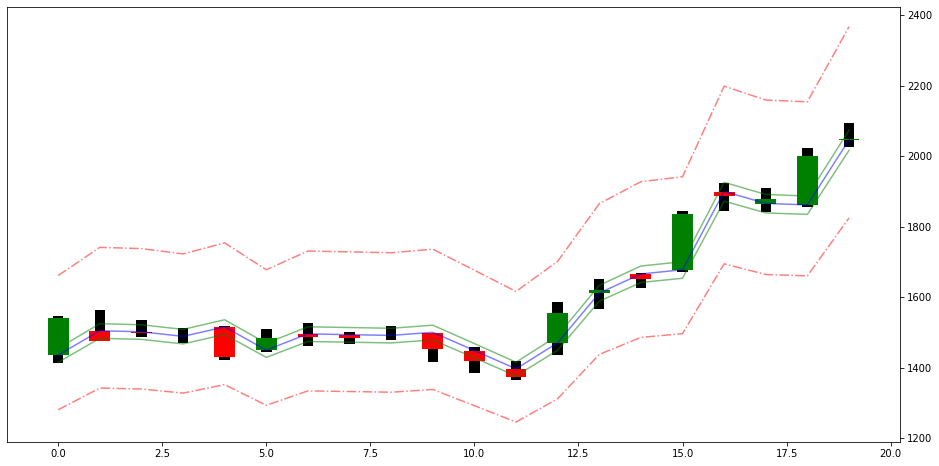

In [655]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plot_candles(df, ax, 20)
plt.show()

In [656]:
iqr_stats(df, c1="Q1", c2="Q3")

Q1-Q3: 51.22%
